# **House selling price prediction**

In [29]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

## **I) Linear Regression**
In this question, we will take a simple dataset and implement linear and ridge regression by solving for their analytical solutions. We will then perform a simple hyperparameter search to determine regression co-efficients that best suit the data.

We'll be using the Boston Housing Dataset, which you can find out more about [here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). The goal is to determine the best way to weight different features of houses to determine the price it was sold for.

The following cell is just for loading the data properly in the format you need. In this case, we load our data as a design matrix $X$ where
$$
X = \begin{bmatrix} x_{11} & \cdots & x_{1d} \\ \vdots & \ddots & \vdots \\ x_{n1} & \cdots & x_{nd} \end{bmatrix}
$$ where each row is an instance of the data. Meanwhile, the targets $y$ is loaded as a single column vector where the $i$-th entry corresponds to the target for the $i$-th row in $X$.

In [30]:
def load_linear_regression_data():
    test_inputs = np.genfromtxt('/data/housing_X_test.csv', delimiter=',')
    test_targets = np.genfromtxt('/data/housing_y_test.csv', delimiter=',')
    train_inputs = np.genfromtxt('/data/housing_X_train.csv', delimiter=',')
    train_targets = np.genfromtxt('/data/housing_y_train.csv', delimiter=',')

    return train_inputs.T, train_targets.reshape((train_targets.shape[0], 1)), test_inputs.T, test_targets.reshape((test_targets.shape[0], 1))

X_tr, y_tr, X_te, y_te = load_linear_regression_data()

### **I)a) Helper functions for processing data**

In [31]:
def create_inputs_with_bias(X: np.ndarray) -> np.ndarray:
    """
    Args:
        X (np.ndarray): Input

    Returns:
        X_new (np.ndarray): Input with biases appended
    """
    n = np.shape(X)[0]
    ones_column = np.ones((n, 1))
    X_new = np.concatenate((X, ones_column), axis=1)
    return X_new


In [32]:
def rmse(y: np.ndarray, y_hat: np.ndarray) -> float:
    """
    Args:
        y (np.ndarray): True labels/values
        y_hat (np.ndarray): Predicted labels/values

    Returns:
        float: Root Mean-Squared Error
    """
    n = np.shape(y)[0]
    return np.sqrt(1/n*((y - y_hat).T)@(y - y_hat))


In [33]:
def predict_linear_regression(inputs: np.ndarray, weights: np.ndarray) -> np.ndarray:
    """
    Args:
        X (np.ndarray): Input
        weights (np.ndarray): Weight vector

    Returns:
        predicted_values: np.ndarray: Predictions
    """
    return np.dot(inputs, weights)


In [34]:
def solve_linear_regression(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Args:
        X (np.ndarray): Input
        y (np.ndarray): Labels

    Returns:
        w_sol (np.ndarray): Analytical solution weight vector
    """
    w_sol = np.linalg.pinv(X)@y
    return w_sol

In [35]:
def solve_ridge_regression(X: np.ndarray, y: np.ndarray, lambda_hyperparameter: float) -> np.ndarray:
    """
    Args:
        X (np.ndarray): Input
        y (np.ndarray): Labels
        lambda_hyperparameter (float): Regularization coefficient

    Returns:
        w_sol (np.ndarray): Analytical solution weight vector
    """
    d = np.shape(X)[1]
    w_sol = np.linalg.solve((X.T)@X + lambda_hyperparameter*np.eye(d), (X.T)@y)
    return w_sol

### **I)b) Cross-validation with linear regression**

Now that we have all of our main functions written out correctly, we would like to perform a hyperparameter search on ridge regression. In particular, we want to find the best regularization co-efficient $\lambda$ based on the housing dataset we currently have. If you recall, ridge regression is a regularized version of linear regression where is loss is calculated as
$$
\tilde{L}(X, y, w) = L(X, y, w) + \lambda \cdot \|w\|_2^2
$$
where $L$ is the loss for linear regression and $w$ is the current weight vector.

Here, we'll perform a $k$-fold cross validation over the samples to estimate the best value of $\lambda$ that enables best transfer from the training dataset to the testing dataset. For those who are still unfamiliar with $k$-fold CV, the idea is to duplicate the training dataset $k$ times, then for each duplicate split the dataset into a training and validation set. For each duplicate, or fold, the validation set should be different from all other folds.

Since there are many ways to perform the splitting, we'll be doing it in a very simple manner. To avoid any random seeding issues, we'll be creating each fold's train/validation sets deterministically.

In [37]:
def cross_validation_linear_regression(k_folds: int, hyperparameters: List[float],
                                       X: np.ndarray, y: np.ndarray) -> Tuple[float, float, List[float]]:
    """
    Args:
        k_folds (int): Number of folds to use
        hyperprameters (np.ndarray): Numpy array of floats containing the hyperparameter values to search
        X (np.ndarray): Numpy array of shape [observations, features]
        y (np.ndarray): Numpy array of shape [observations, 1]

    Returns:
        best_hyperparam: np.float value corresponding to the best hyperparameter value
        best_root_mean_squared_error: np.float value corersponding to the best RMSE value
        root_mean_squared_errors: np.ndarray of size len(hyperparameters) containing the corresponding RMSE for reach hyperparameter value
    """

    best_hyperparam = 0.0
    best_root_mean_squared_error = 0.0
    root_mean_squared_errors = np.zeros(len(hyperparameters))

    for i in range(k_folds):
        # Split data into train and test
        X_train = np.concatenate((X[:i*int(X.shape[0]/k_folds), :], X[(i+1)*int(X.shape[0]/k_folds):, :]), axis=0)
        y_train = np.concatenate((y[:i*int(y.shape[0]/k_folds)], y[(i+1)*int(y.shape[0]/k_folds):]), axis=0)

        X_valid = X[i*int(X.shape[0]/k_folds):(i+1)*int(X.shape[0]/k_folds), :]
        y_valid = y[i*int(y.shape[0]/k_folds):(i+1)*int(y.shape[0]/k_folds)]

        # Solve linear regression for each hyperparameter
        for j in range(len(hyperparameters)):
            w_sol = solve_ridge_regression(X_train, y_train, hyperparameters[j])
            y_hat = predict_linear_regression(X_valid, w_sol)
            root_mean_squared_errors[j] += rmse(y_valid, y_hat)/k_folds

    # Store best results
    best_root_mean_squared_error = np.min(root_mean_squared_errors)
    best_hyperparam = hyperparameters[np.argmin(root_mean_squared_errors)] 

    return best_hyperparam, best_root_mean_squared_error, root_mean_squared_errors

### **I)c) Hyperparameter search**

In [39]:
# lambda values to be evaluated by cross validation
hyperparams = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
               1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4,
               2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
k_folds = 10

# Perform cross validation on training set
best_lambda_tr, best_root_mean_squared_error_tr, root_mean_squared_errors_tr = cross_validation_linear_regression(k_folds, 
                                                                                                                  hyperparams, 
                                                                                                                  create_inputs_with_bias(X_tr),
                                                                                                                  y_tr)

print("Results for training set:")
print('best lambda: ' + str (best_lambda_tr))
print('best cross validation root mean squared error: ' + str(best_root_mean_squared_error_tr))
print('test root mean squared error: ' + str(root_mean_squared_errors_tr))


# Perform cross validation on test set
best_lambda_te, best_root_mean_squared_error_te, root_mean_squared_errors_te = cross_validation_linear_regression(k_folds, 
                                                                                                                  hyperparams, 
                                                                                                                  create_inputs_with_bias(X_te),
                                                                                                                  y_te)

print("\nResults for test set:")
print('best lambda: ' + str (best_lambda_te))
print('best cross validation root mean squared error: ' + str(best_root_mean_squared_error_te))
print('test root mean squared error: ' + str(root_mean_squared_errors_te))


Results for training set:
best lambda: 0.7
best cross validation root mean squared error: 3.456353263569991
test root mean squared error: [3.57074823 3.49979317 3.47555585 3.46481248 3.45966016 3.45726822
 3.45637858 3.45635326 3.45683944 3.45762997 3.45859809 3.45966391
 3.46077616 3.46190158 3.46301857 3.4641132  3.46517674 3.46620391
 3.46719183 3.46813924 3.46904601 3.46991273 3.47074051 3.47153079
 3.47228518 3.47300542 3.4736933  3.47435061 3.4749791  3.4755805
 3.47615647]

Results for test set:
best lambda: 0.1
best cross validation root mean squared error: 5.480822455368664
test root mean squared error: [5.79068372 5.48082246 5.61390744 5.73020342 5.81026994 5.86466278
 5.90200431 5.92787842 5.94585568 5.95826928 5.96668561 5.97218366
 5.97552388 5.97725291 5.97777049 5.97737318 5.97628382 5.97467157
 5.97266607 5.97036738 5.96785324 5.96518432 5.96240818 5.95956217
 5.9566757  5.95377188 5.9508689  5.94798101 5.9451193  5.94229238
 5.93950683]


According to this k-fold cross validation, the best hyperparameter value is 0.7 for the training set and 0.1 for the test set.
We can see that it performs less well on the test set as the test RMSEs are almost the double values of training RMSEs but still, the test RMSEs keep the same magnitude as training RMSEs.

### **I)d) Plots**

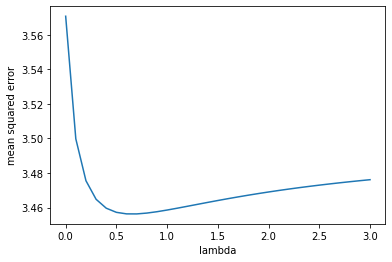

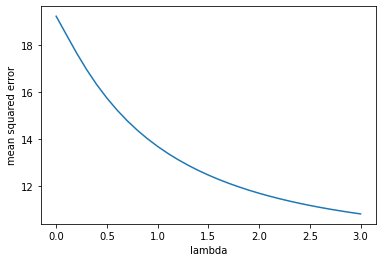

In [40]:
def plot_linear_regression_root_mean_squared_errors(root_mean_squared_errors, hyperparams):
    plt.plot(hyperparams, root_mean_squared_errors)
    plt.ylabel('mean squared error')
    plt.xlabel('lambda')
    plt.show()

# plot results
plot_linear_regression_root_mean_squared_errors(root_mean_squared_errors_tr, hyperparams)

test_rmse = np.zeros(len(hyperparams))

"""
Write code to find the test RMSE for all hyperparameters using the train set to find w
"""
train_inputs = create_inputs_with_bias(X_tr)
test_inputs = create_inputs_with_bias(X_te)

for j in range(len(hyperparams)):
    w_sol = solve_ridge_regression(train_inputs, y_tr, hyperparams[j])
    y_hat = predict_linear_regression(test_inputs, w_sol)
    test_rmse[j] += rmse(y_te, y_hat)

plot_linear_regression_root_mean_squared_errors(test_rmse, hyperparams)

We can see that $\lambda = 0.7$ obtained from cross-validation seems to be a good solution but regarding orders of magnitude it seems that larger values of $\lambda$ are more interesting as they minimize the test RMSE and lead to a very little increase of validation RMSE. On the other hand, we can see that small values of $\lambda$ make the test RMSE explode and validation RMSE increase too so they are not interesting here.

## **II) Gradient descent**

We'll now use a synthetically generated dataset.

In [41]:
def load_gd_data(working_dir):
    test_inputs = np.genfromtxt(working_dir + '/data/test_inputs.csv', delimiter=',')
    test_targets = np.genfromtxt(working_dir + '/data/test_targets.csv', delimiter=',')
    train_inputs = np.genfromtxt(working_dir + '/data/train_inputs.csv', delimiter=',')
    train_targets = np.genfromtxt(working_dir + '/data/train_targets.csv', delimiter=',')

    return train_inputs, train_targets.reshape((train_targets.shape[0], 1)), test_inputs, test_targets.reshape((test_targets.shape[0], 1))

X_tr, y_tr, X_te, y_te = load_gd_data()

### **II)a) Linear regression using Gradient descent**

Along with linear and ridge regression, we introduce LASSO regression, which is similar to ridge regression but instead of using a penalty term of $\|w\|_2^2$, we use a penalty of $\|w\|_1$. Since you might not be familiar with this notation, we denote the function $f(\cdot) = \| \cdot \|_1$ as the L1-norm function, where
$$
\| w \|_1 = |w_1| + |w_2| + \dots + |w_d|
$$

Let's provide a function that computes the gradient for all three regression types.

In [42]:
def linear_regression_gradient(X: np.ndarray, y: np.ndarray, w: np.ndarray, **kwargs) -> np.ndarray:
    """Compute the gradient of w with respect to the loss

    Args:
        X (np.ndarray): Numpy array of shape [observations, features]
        y (np.ndarray): Numpy array of shape [observations, 1]
        w (np.ndarray): Numpy array of shape [features, 1], where the last value is w_0 and all other values represent w_1

    Returns:
        np.ndarray: Gradient of w with respect to the loss, as a numpy array of the same shape as w.
    """
    y_hat = predict_linear_regression(X, w)
    n = y.shape[0]
    
    return 1/n*(X.T)@(y_hat - y)


In [43]:
def ridge_regression_gradient(X: np.ndarray, y: np.ndarray, w: np.ndarray, hyperparameter: float, **kwargs) -> np.ndarray:
    """Compute the gradient of w with respect to the loss

    Args:
        X (np.ndarray): Numpy array of shape [observations, features]
        y (np.ndarray): Numpy array of shape [observations, 1]
        w (np.ndarray): Numpy array of shape [features, 1], where the last value is w_0 and all other values represent w_1
        hyperparameter (float): Lambda used in L2 regularizer

    Returns:
        np.ndarray: Gradient of w with respect to the loss, as a numpy array of the same shape as w.
    """
    y_hat = predict_linear_regression(X, w)
    n = y.shape[0]

    return 1/n*(X.T)@(y_hat - y) + 2*hyperparameter*w
    

In [44]:
def lasso_regression_gradient(X: np.ndarray, y: np.ndarray, w: np.ndarray, hyperparameter: float, **kwargs) -> np.ndarray:
    """Compute the gradient of w with respect to the loss

    Args:
        X (np.ndarray): Numpy array of shape [observations, features]
        y (np.ndarray): Numpy array of shape [observations, 1]
        w (np.ndarray): Numpy array of shape [features, 1], where the last value is w_0 and all other values represent w_1
        hyperparameter (float): Lambda used in L2 regularizer

    Returns:
        np.ndarray: Gradient of w with respect to the loss, as a numpy array of the same shape as w.
    """
    y_hat = predict_linear_regression(X, w)
    n = y.shape[0]
    
    return 1/n*(X.T)@(y_hat - y) + hyperparameter*np.sign(w)


In [46]:
def regression_gradient_descent(X_train: np.ndarray, y_train: np.ndarray,
                                X_test: np.ndarray, y_test: np.ndarray,
                                w_0: np.ndarray, hyperparameter: float,
                                learning_rate: float, num_epochs: int, reg_type: str = 'linear') -> Tuple[List[float], List[float], np.ndarray]:
    """ Runs gradient descent to optimize the parameters w.

    Args:
        y_train (np.ndarray): Numpy array of shape [observations, 1]
        X_train (np.ndarray): Numpy array of shape [observations, features]
        X_test (np.ndarray): Numpy array of shape [observations, features]
        y_test (np.ndarray): Numpy array of shape [observations, 1]
        w_0 (np.ndarray): Numpy array of shape [features, 1]
        hyperparameter (float): Lambda used in L2 regularizer
        learning_rate (float): Value to multiply our gradient with before updating our parameters.
        num_epochs (int): Number of gradient descent steps to perform.
        type (str): The type of regression to use ['linear', 'ridge', 'lasso']

    Returns:
        train_loss (np.ndarray): The train RMSE loss without L2 regularizer, for each step.
        test_loss (np.ndarray): The validation RMSE loss without L2 regularizer, for each step.
        optimized_w (np.ndarray): The optimized w parameters.
    """

    valid = {'linear', 'ridge', 'lasso'}
    if reg_type not in valid:
        raise ValueError("Invalid regression type")

    train_losses = np.zeros((num_epochs,), dtype=np.float32)
    test_losses = np.zeros((num_epochs,), dtype=np.float32)
    w_sol = np.copy(w_0)

    for i in range(num_epochs):

        # Choose of gradient according to the regression type
        if reg_type == 'linear':
            grad = linear_regression_gradient(X_train, y_train, w_sol)
        elif reg_type == 'ridge':
            grad = ridge_regression_gradient(X_train, y_train, w_sol, hyperparameter)
        elif reg_type == 'lasso':
            grad = lasso_regression_gradient(X_train, y_train, w_sol, hyperparameter)
        else:
            raise ValueError("Invalid regression type")
        
        # Computation of the losses
        train_losses[i] = rmse(y_train, predict_linear_regression(X_train, w_sol))
        test_losses[i] = rmse(y_test, predict_linear_regression(X_test, w_sol))

        # Update of the weights at the end
        w_sol -= learning_rate*grad

    return (train_losses, test_losses, w_sol)

### **II)b) Find the solution weights for each type of regression and Plots**

In [48]:
num_epochs = 250
hyperparameter = 0.15
learning_rate = 0.01

# add bias at the end of each data point
train_inputs = create_inputs_with_bias(X_tr)
test_inputs = create_inputs_with_bias(X_te)

w_0 = np.random.normal(size=(train_inputs.shape[1], 1))

"""
Write code here to find the solution for each method.
"""

train_losses, test_losses, _ = regression_gradient_descent(train_inputs, y_tr, 
                                                           test_inputs, y_te, 
                                                           w_0, hyperparameter, learning_rate, num_epochs, 'linear')

train_losses_ridge, test_losses_ridge, _ = regression_gradient_descent(train_inputs, y_tr, 
                                                                       test_inputs, y_te, 
                                                                       w_0, hyperparameter, learning_rate, num_epochs, 'ridge')

train_losses_lasso, test_losses_lasso, _ = regression_gradient_descent(train_inputs, y_tr, 
                                                                       test_inputs, y_te, 
                                                                       w_0, hyperparameter, learning_rate, num_epochs, 'lasso')

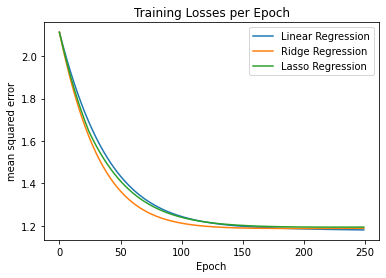

In [49]:
plt.plot(train_losses, label='Linear Regression')
plt.plot(train_losses_ridge, label='Ridge Regression')
plt.plot(train_losses_lasso, label='Lasso Regression')
plt.ylabel('mean squared error')
plt.xlabel('Epoch')
plt.title('Training Losses per Epoch')
plt.legend(loc = 'upper right')
plt.show()

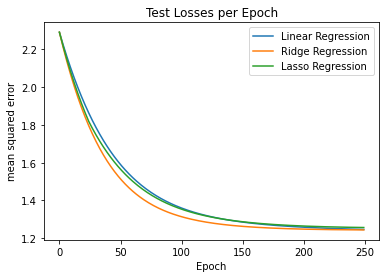

In [50]:
plt.plot(test_losses, label='Linear Regression')
plt.plot(test_losses_ridge, label='Ridge Regression')
plt.plot(test_losses_lasso, label='Lasso Regression')
plt.ylabel('mean squared error')
plt.xlabel('Epoch')
plt.title('Test Losses per Epoch')
plt.legend(loc = 'upper right')
plt.show()

### **II)c) Regularization with hyperparameter equal to 1**

In [51]:
def load_comp_data():
    test_inputs = np.genfromtxt('/data/X_test_C.csv', delimiter=',')
    test_targets = np.genfromtxt('/data/Y_test_C.csv', delimiter=',')
    train_inputs = np.genfromtxt('/data/X_train_C.csv', delimiter=',')
    train_targets = np.genfromtxt('/data/Y_train_C.csv', delimiter=',')

    return train_inputs, train_targets.reshape((train_targets.shape[0], 1)), test_inputs, test_targets.reshape((test_targets.shape[0], 1))

X_train, y_train, X_test, y_test = load_comp_data()

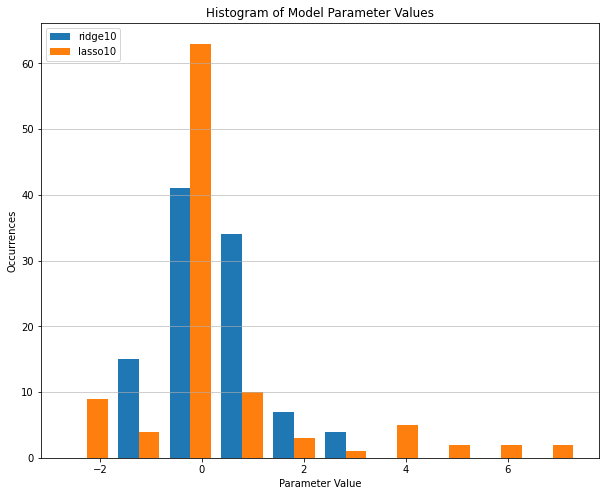

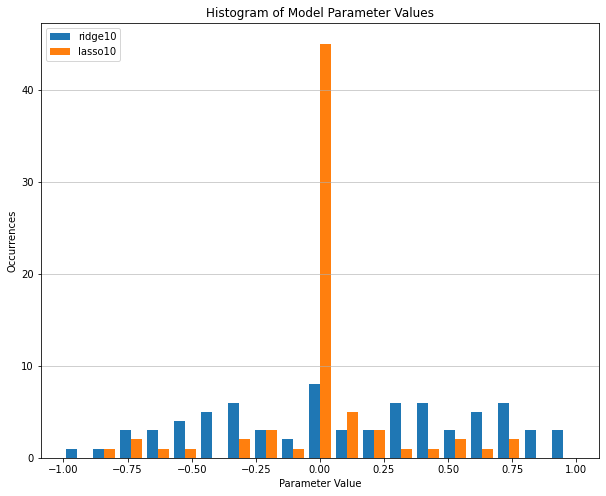

In [52]:
train_inputs = create_inputs_with_bias(X_train)
test_inputs = create_inputs_with_bias(X_test)

np.random.seed(8245)
w_0 = np.random.normal(size=(train_inputs.shape[1], 1))

hyperparameter = 1

_, _, w_sol_ridge = regression_gradient_descent(train_inputs, y_train, test_inputs, y_test, w_0, hyperparameter, learning_rate, num_epochs, 'ridge')

_, _, w_sol_lasso = regression_gradient_descent(train_inputs, y_train, test_inputs, y_test, w_0, hyperparameter, learning_rate, num_epochs, 'lasso')

data = [w_sol_ridge.flatten(), w_sol_lasso.flatten()]
labels = ['ridge10', 'lasso10']
plt.figure(figsize = (10, 8))
plt.hist(data, label=labels)

plt.grid(axis='y', alpha=0.75)
plt.legend(loc = 'upper left')
plt.title('Histogram of Model Parameter Values')
plt.ylabel('Occurrences')
plt.xlabel('Parameter Value')
plt.show()

data = [w_sol_ridge.flatten(), w_sol_lasso.flatten()]
labels = ['ridge10', 'lasso10']

bins = np.linspace(-1, 1, 20)
plt.figure(figsize = (10, 8))
plt.hist(data, bins = bins, label=labels)

plt.grid(axis='y', alpha=0.75)
plt.legend(loc = 'upper left')
plt.title('Histogram of Model Parameter Values')
plt.ylabel('Occurrences')
plt.xlabel('Parameter Value')
plt.show()

For Lasso regression, I notice that almost all the weights have as value 0 or a value close to 0 whereas for Ridge regression the weights are also close to 0 but more equally distributed as we can see in the second graph between $[-1, 1]$ they are all under 10 occurences while Lasso has the weight 0 with more than 40 occurences and the rest under 10.

As the regularization term is 1 it may be at the cause of this phenomenon. Indeed, with Lasso 1 as regularization is more likely to push some features weights to 0, excluding them from the model while with Ridge the weights are reduced more smoothly close to 0.

### **II)d) Mathematical explanation of the previous results**

If we use the following notations :
$$X = \begin{pmatrix} x_1 \\ \vdots \\  x_n \end{pmatrix}$$

$$Y = \begin{pmatrix} y_1 \\ \vdots \\  y_n \end{pmatrix}$$

$$\omega = \begin{pmatrix} \omega _1 \\ \vdots \\  \omega _n \end{pmatrix}$$

According to the definitions of Lasso and Ridge losses :
$$L_{Lasso}(\omega)= \sum\limits_{i=1}^n (x_i\omega - y_i)^2 + \lambda\times\lVert\omega\rVert _1$$
$$L_{Ridge}(\omega)= \sum\limits_{i=1}^n (x_i\omega - y_i)^2 + \lambda\times\lVert\omega\rVert _2^2$$

Here, we took $\lambda = 1$ so we have :
$$L_{Lasso}(\omega)= \sum\limits_{i=1}^n (x_i\omega - y_i)^2 + \lVert\omega\rVert _1$$
$$L_{Ridge}(\omega)= \sum\limits_{i=1}^n (x_i\omega - y_i)^2 + \lVert\omega\rVert _2^2$$

However, $x \mapsto \lVert x \rVert _2^2$ is differentiable in 0 while $x \mapsto \lVert x \rVert _1 = \sum\limits_{i=1}^n \lvert x_i \rvert$ is not differentiable in 0 because $x \mapsto \lvert x \rvert$ is not differentiable in 0.

Hence, Lasso encourages sparsity among the weights while Ridgle only encourages to a decrease of the weights values.

<!-- END QUESTION -->

